In [1]:
import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os

from egnn_pytorch import EGNN_Network
import torch
import torch.nn as nn

import math

#EGNN
class EGNNBlock(nn.Module):
    """todo: try to take head out here
    egnn_net --> layer norm --> ffn head"""
    def __init__(self, dim, depth,hidden_dim,dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.egnn = EGNN_Network(
            dim=dim, depth=depth, dropout=dropout,
            num_positions=num_positions,
            num_tokens=num_tokens,
            num_nearest_neighbors=num_nearest_neighbors,
            norm_coors=norm_coors
        )
        self.norm1 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, hidden_dim*dim),
            nn.PReLU(),# LU(),
            nn.Linear(hidden_dim*dim, dim),
        )
        self.norm2 = nn.LayerNorm(dim)
    def forward(self, z, x):
        (h_list, coords) = self.egnn(z, x)
        h = h_list # [B,N,dim]
        h2 = h
        h  = self.norm1(h + h2)
        h2 = self.ffn(h)
        h  = self.norm2(h + h2)
        return [h], coords

class StackedEGNN(nn.Module):
    """TODO understand depth"""
    def __init__(self, dim, depth, hidden_dim, dropout,
                 num_positions, num_tokens,
                 num_nearest_neighbors,
                 norm_coors,
                 num_global_tokens, num_edge_tokens):
        super().__init__()
        self.blocks = nn.ModuleList([
            EGNNBlock(dim, depth, hidden_dim, dropout,
                      num_positions, num_tokens,
                      num_nearest_neighbors,
                      norm_coors,
                      num_global_tokens, num_edge_tokens)
            for _ in range(1)
        ])
    def forward(self, z, x):
        coords = x
        h_list = None
        for block in self.blocks:
            if h_list is None:
                h_list, coords = block(z, x)
            else:
                h_list, coords = block(z, coords)
        return h_list, coords

# --- RBF with learnable cutoff ---
class LearnableRBF(nn.Module):
    """TODO change cutout"""
    def __init__(self, num_basis=16, cutoff=10.0):
        super().__init__()
        #self.pairwise = torch.norm(x.unsqueeze(1) - x.unsqueeze(0), dim=-1)
        self.cutoff = nn.Parameter(torch.tensor(cutoff))
        self.mu     = nn.Parameter(torch.linspace(0.0, 1.0, num_basis))
        self.gamma  = nn.Parameter(torch.tensor(12.0))
    
    def pairwise_distances(self, dist):
        return torch.norm(dist.unsqueeze(1) - dist.unsqueeze(0), dim=-1)

    
    def forward(self, dist):
        # dist: [B,N,N]
        dist = self.pairwise_distances(dist)
        mu = self.mu * self.cutoff     # [K]
        d  = dist.unsqueeze(-1)        # [B,N,N,1]
        return torch.exp(-self.gamma * (d - mu)**2)


#Attn. note encoding dropout of 0.03
#TODO: SPECIFy max len and dropout.
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=1000, dropout=0.03):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        pos = torch.arange(max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float)
                        * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(pos * div)
        cosp = torch.cos(pos * div)
        pe[:, 1::2] = cosp[:, : pe[:, 1::2].shape[1]]
        self.register_buffer('pe', pe.unsqueeze(1))
    def forward(self, x):
        return self.dropout(x + self.pe[: x.size(0)])

# --- Transformer‐style AttentionBlock ---
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_

class head(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim):
        super().__init__()
        self.encoding = PositionalEncoding(embed_dim)
        self.attn  = nn.MultiheadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ffn   = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * hidden_dim),
            nn.PReLU(),
            nn.Linear(embed_dim * hidden_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        
    def forward(self, x, key_padding_mask=None):
        # x: [seq_len, batch, embed_dim]
        x = self.encoding(x)
        a, _ = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        x    = self.norm1(x + a)
        f    = self.ffn(x)
        x    = self.norm2(x + f)
        return x,_




import datetime, time
#from architecture import *
import torch
import glob, math, time, datetime
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from egnn_pytorch import EGNN_Network
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
from egnn_pytorch import EGNN
# 0) start timer
t0 = time.time()
N_NEIGHBORS = 100
BATCH_SIZE  =  1         # not safe to increase
PIN_MEMORY  = torch.cuda.is_available()
# reproducibility + device
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv=nn.Conv1d(1, 1, 7, padding=3).to(device)
# decide AMP only on GP0
use_amp = (device.type == "cuda")
if use_amp:
    scaler = GradScaler()
else:
    class DummyCM:
        def __enter__(self): pass
        def __exit__(self, *args): pass
    autocast = DummyCM
    scaler   = None
#{'runid': '20250714_013739', 'num_nbrs': 100, 'num_nbrs_egnn': 8, 'learning_rate': [0.005], 'dataset': ('inputs_test/*.npz', 1042), 'epochs': 50, 'dim': 12, 'depth': 4, 'basis': 64, 'hidden_dim': 4, 'dropout': [0.01, 0.03], 'rbf cutoff': 20.0, 'loss': L1Loss(), 'params': 102458}
#.4045 val
def init_model(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout):
    
    def build_egnn(dim,depth,hidden_dim,num_neighbors, num_edge_tokens,num_global_tokens,dropout):
        return StackedEGNN(
            dim=dim, depth=depth, hidden_dim=hidden_dim,
            dropout=dropout,
            num_positions=N_NEIGHBORS, num_tokens=118,
            num_nearest_neighbors=num_neighbors,
            norm_coors=True,
            num_edge_tokens=num_edge_tokens,
            num_global_tokens=num_global_tokens
        )
    net   = build_egnn(dim,depth,hidden_dim,num_neighbors,num_edge_tokens,num_global_tokens,dropout).to(device)
    mha   = AttentionBlock(embed_dim=dim+basis, num_heads=num_heads, hidden_dim=hidden_dim).to(device)
    RBF   = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device) 
    return net, mha, RBF
#net,mha,RBF=init_model
# 3) instantiate everything
dim, basis = 3, 3 #scale to 3,16 at least # dim must be divisible by 2
depth=2 #scale to 2, at least
hidden_dim=2
num_heads=(dim + basis ) 
num_edge_tokens=10
num_global_tokens=10
dropout=0.03
cutoff=20.0
num_neighbors=11



runid=datetime.datetime.now().strftime("%Y%m%d_%H%M%S")


from sklearn.neighbors import NearestNeighbors
from torch.utils.data import Dataset, DataLoader
import numpy as np, torch, glob

class InMemoryHoodDataset(Dataset):
    """
    Loads *.npz files, constructs fixed-size neighbourhoods around each
    site (anchor) and stores the result entirely in RAM.

    For a protein with S sites the shapes are
        z   : (S, N_NEIGHBORS)      int32
        pos : (S, N_NEIGHBORS, 3)   float32
        y   : (S,)                  float32
    """
    def __init__(self, paths, n_neighbors=N_NEIGHBORS, pin_memory=PIN_MEMORY):
        super().__init__()
        self.data = []
        nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute")

        for p in paths:
            try:
                dat = np.load(p, allow_pickle=True)
                #print(dat.keys(),p)
                #return
                z_all   = dat["z"].astype(np.int32)        # (N,)
                pos_all = dat["pos"].astype(np.float32)    # (N,3)
                sites   = dat["sites"].astype(np.float32)  # (S,3)
                y       = dat["pks"].astype(np.float32)    # (S,)

                if len(sites) == 0:
                    continue  # skip empty entries

                nbrs.fit(pos_all)
                idx = nbrs.kneighbors(sites, return_distance=False)   # (S, N_NEIGHBORS)

                z_hood   = torch.from_numpy(z_all[idx])            # (S,N_NEIGHBORS)
                pos_hood = torch.from_numpy(pos_all[idx])          # (S,N_NEIGHBORS,3)
                y        = torch.from_numpy(y)                     # (S,)

                if pin_memory:
                    z_hood   = z_hood.pin_memory()
                    pos_hood = pos_hood.pin_memory()
                    y        = y.pin_memory()

                self.data.append((z_hood, pos_hood, y))
            except Exception as e:
                print(f"skipping {p}: {e}")

    def __len__(self):             return len(self.data)
    def __getitem__(self, idx):    return self.data[idx]

# ---------------------------------------------------------------------
# 2) collate function  -------------------------------------------------
# ---------------------------------------------------------------------
def pad_collate(batch):
    B      = len(batch)
    S_max  = max(item[0].shape[0] for item in batch)   # longest protein

    # --- allocate on CPU (no device=...) ---------------
    zs   = torch.zeros (B, S_max, N_NEIGHBORS ,   dtype=torch.int32 )
    pos  = torch.zeros (B, S_max, N_NEIGHBORS ,3, dtype=torch.float32)
    ys   = torch.full  ((B, S_max), float("nan"),  dtype=torch.float32)
    mask = torch.zeros (B, S_max,               dtype=torch.bool)

    for b,(z,pos_b,y) in enumerate(batch):
        S = z.shape[0]
        zs [b, :S] = z
        pos[b, :S] = pos_b
        ys [b, :S] = y
        mask[b, :S] = True

    return zs, pos, ys, mask


def count_params(model: torch.nn.Module, trainable_only: bool = True) -> int:
    """
    Returns the total number of (optionally trainable) parameters.
    """
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in model.parameters())


# ---------------------------------------------------------------------
# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------

# 0) parameters you might want to expose at the top of the script
# ---------------------------------------------------------------------

# 3) data loaders ------------------------------------------------------
# ---------------------------------------------------------------------
np.random.seed(0)
INPUTS_DIR="../inputs/*.npz"
all_paths = sorted(glob.glob(INPUTS_DIR))
#print(all_paths)
#split=0.75
#t=int(len(all_paths) *.75) - 1

#v=int(len(all_paths) *.25)
np.random.shuffle(all_paths)
train_paths, val_paths = all_paths[:200] + all_paths[500:], all_paths[200:500]
#print(train_paths[0],val_paths[0])
nconv=nn.Conv1d(N_NEIGHBORS,1,dim+basis).to(device)
train_ds = InMemoryHoodDataset(train_paths)
val_ds   = InMemoryHoodDataset(val_paths)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                          shuffle=True,  collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds  , batch_size=BATCH_SIZE,
                          shuffle=False, collate_fn=pad_collate,
                          num_workers=0, pin_memory=PIN_MEMORY)


# ---------------------------------------------------------------------
# 4) model pieces ------------------------------------------------------
# ---------------------------------------------------------------------
egnn_net = StackedEGNN(dim=dim, depth=depth, hidden_dim=hidden_dim,
                       dropout=dropout, num_positions=1000, num_tokens=118,
                       num_nearest_neighbors=num_neighbors,
                       norm_coors=True,
                       num_edge_tokens=num_edge_tokens,
                       num_global_tokens=num_global_tokens).to(device)

rbf_layer = LearnableRBF(num_basis=basis, cutoff=cutoff).to(device)
mha_layer = AttentionBlock(embed_dim=dim + basis,
                           num_heads=num_heads,
                           hidden_dim=hidden_dim).to(device)
pred_head = nn.Linear(1, 1).to(device)
pred_head2 = nn.Linear(1, 1).to(device)

protein_egnn=EGNN(dim=1,update_coors=True, norm_coors=True, norm_feats=True, fourier_features=6, valid_radius=8)
criterion = nn.L1Loss()
optimizer = torch.optim.AdamW(
    list(egnn_net.parameters()) +
    list(rbf_layer.parameters()) +
    list(mha_layer.parameters()) +
    list(conv.parameters()) +
    list(nconv.parameters()) +

    list(pred_head.parameters()) +
    list(protein_egnn.parameters()),
    lr=5e-3
)
modell=[egnn_net, protein_egnn, nconv,rbf_layer,mha_layer,pred_head,conv]
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=.99, patience=0, cooldown=0, min_lr=1e-8, verbose=False)
epochs = 200 # or whatever you like
total_all    = count_params(torch.nn.ModuleList(
                    modell))

#print(f"Atom-level EGNN      : {total_egnn:,}")
#print(f"Residue-level EGNN   : {total_res:,}")
#print(f"Prediction head      : {total_head:,}")
print(f"Whole model          : {total_all:,}")

config={"runid": runid,
        "num_nbrs": N_NEIGHBORS,
        "num_nbrs_egnn": num_neighbors,
        "learning_rate": [op["lr"] for op in optimizer.param_groups], #net mha model rbf
        "dataset": (INPUTS_DIR,len(train_ds),len(val_ds)),
        "epochs": epochs,
        "dim": dim,
        "depth": depth,
        "basis": basis,
        "hidden_dim":hidden_dim,
        "num_heads":num_heads,
        "dropout": [dropout, 0.03], #egnn p.enc. 
        "rbf cutoff": cutoff,
        "loss": criterion,
        "params":total_all}
        #"architect":str(modell).encode()}

print(config)
# ---------------------------------------------------------------------
# 5) forward for a *compressed* batch (R residues, N neighbours)
# ---------------------------------------------------------------------
# ---------------------------------------------------------------------
# 5) single-path forward – no shape guessing, no branching
# ---------------------------------------------------------------------
def forward_residues(z_r, x_r):
    """
    z_r : (R, N)       int32   – atomic numbers for R residues
    x_r : (R, N, 3)    float32 – coordinates
    returns (R, dim + basis)   – per-residue embeddings
    """
    # ---------- EGNN ----------
    h_out, coords = egnn_net(z_r, x_r)          # h_out is [tensor] or tensor
    h = h_out[0] if isinstance(h_out, (list, tuple)) else h_out   # (R, N, dim)

    # ---------- RBF on *input* coords (already (R,N,3)) ----------
    #d   = torch.cdist(x_r, x_r)            # (R, N, N)
    rbf = rbf_layer(coords)                     # (R, N, N, basis)
    

    # ---------- concat & attention ----------
    h0  = h.transpose(1, 2)                # (R, dim,   N)
    r0  = rbf[:, 0].transpose(1, 2)        # (R, basis, N)
    tok = torch.cat((r0, h0), dim=1)       # (R, dim+basis, N)

    tok, _ = mha_layer(tok.permute(2, 0, 1))   # (N, R, C) → attn(+PE) #TODO suppress _
    tok=nconv(tok.to(device).permute(1,0,2)).to(device)
    #tok    = tok.permute(1, 0, 2).max(dim=1).values   # (R, C) max over neighbours
    return tok,     coords.mean(dim=1).unsqueeze(0)                               # (R, dim + basis)
                                         # (R, dim+basis)

# ---------------------------------------------------------------------
# 6) training / validation loop ---------------------------------------
# ---------------------------------------------------------------------
tloss, vloss = [], []
for epoch in range(epochs):
    # ======== TRAIN ========
    egnn_net.train(); rbf_layer.train(); mha_layer.train(); protein_egnn.train(); conv.train(); nconv.train();pred_head.train(); pred_head2.train(); 
    tr_losses = []

    for z, x, y, mask in train_loader:                 # z:(B,S,N)  mask:(B,S)
        # compress away padding →  (R, N), (R, N, 3), (R,)
        valid      = mask.view(-1)
        z_res      = z.view(-1, z.size(2))[valid].to(device)
        x_res      = x.view(-1, x.size(2), 3)[valid].to(device)
        y_res      = y.view(-1)[valid].to(device)

        optimizer.zero_grad()

        #model
        feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        #print(feats)
        preds = pred_head(feats.to(device))    
        t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
        centroids = centroids.to(device)  # (1, R, 3) on GPU

        protein_egnn = protein_egnn.to(device)             # make sure weights are there
        preds = protein_egnn(t, centroids)[0].permute(1,2,0)
        #preds = pred_head2(preds.to(device))
        #loss  = criterion(preds.flatten(), y_res)
        with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            

        if use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()

        tr_losses.append(loss.item())
    tmean=np.mean(tr_losses)

    print(f"Epoch {epoch:3d} | train L1 = {tmean:.4f}")
    tloss.append(tmean.item())
    #elapsed_min = (time.time() - t0) / 60
    
    # ======== VALID ========
    egnn_net.eval(); rbf_layer.eval(); mha_layer.eval(); protein_egnn.eval(); conv.eval(); nconv.eval();pred_head.eval(); pred_head2.eval(); 
    vl_losses = []

    with torch.no_grad():
        for z, x, y, mask in val_loader:
            valid   = mask.view(-1)
            z_res   = z.view(-1, z.size(2))[valid].to(device)
            x_res   = x.view(-1, x.size(2), 3)[valid].to(device)
            y_res   = y.view(-1)[valid].to(device)

                #model
            feats, centroids = forward_residues(z_res, x_res)         # (R, C)
        
            preds = pred_head(feats.to(device))    
            t         = preds.to(device)[:,0].T.unsqueeze(2)         # (1, R, 1) on GPU
            centroids = centroids.to(device)  # (1, R, 3) on GPU

            protein_egnn = protein_egnn.to(device)             # make sure weights are there
            preds = protein_egnn(t, centroids)[0].permute(1,2,0)
            #preds = pred_head2(preds.to(device))
            with autocast():
                preds=conv(preds).to(device)

                loss  = criterion(preds.flatten(), y_res)
            vl_losses.append(loss) ###his is so inefficient. batch the proteins and for free bye cpu

    #elapsed_min = (time.time() - t0) / 60
    if vl_losses: #cpu
        vl=torch.mean(torch.stack(vl_losses))
        print(f"              |  val L1 = {vl.item():.4f}")
    #L=torch.mean(torch.stack(vl_losses))
        scheduler.step(vl)
        vloss.append(vl.item())
    
# 5) save a single timestamped checkpoint
elapsed_min = (time.time() - t0) / 60
timestamp   = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint = {
    "epoch":         epoch+1,
    "elapsed_min":   elapsed_min,
    "net":           egnn_net.state_dict(),
    "mha":           mha_layer.state_dict(),
    "model":         protein_egnn.state_dict(),
    "convs":         [conv.state_dict(), nconv.state_dict()],
    "lin":           pred_head.state_dict(),
    #"lin2":          pred_head2.state_dict(),
    "rbf":           rbf_layer.state_dict(),
    "optimizer":     optimizer.state_dict(),
    "scheduler":     scheduler.state_dict(),
    "train_history": tloss,
    "val_history":   vloss,
    "config":        config,
}
torch.save(checkpoint, f"./p50inputs_{runid}-checkpoint_{timestamp}.pt")
#torch.save(checkpoint, f"./test-checkpoint_{timestamp}.pt")
print(f"Saved checkpoint_{timestamp}.pt ({elapsed_min:.1f} min)",elapsed_min)
#os.system("wandb sync --include-offline --sync-all wandb")

#from matplotlib import pyplot as plt
#plt.plot(vloss)
#plt.plot(tloss)


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
# If you’d rather use HDBSCAN uncomment the next line and pip-install hdbscan
# from hdbscan import HDBSCAN
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GroupShuffleSplit

# ----------------------------------------------------------------------------
# 1) LOAD YOUR FEATURE MATRIX
# ----------------------------------------------------------------------------
# Replace this path with wherever your .npy is
#X = np.load("../inputs5/1fvc.npz")
#X=np.column_stack((X["pos"],X["z"]))  # shape: (n_samples, d)
for x, z, _,_ in train_loader:
    #print(x.shape,z)
    t=np.hstack((x.unsqueeze(0),z[0,:].permute(2,0,1).unsqueeze(0)))
t.shape
_, n_features, n_samples, _ = t.shape
print(f"Loaded X with {n_samples} samples and {n_features} features")
X=t
# ----------------------------------------------------------------------------
# 2) STANDARDIZE
# ----------------------------------------------------------------------------
Xs = StandardScaler().fit_transform(X)

# ----------------------------------------------------------------------------
# 3) PCA (up to 50 comps or data dims)
# ----------------------------------------------------------------------------
n_comp = min(50, n_samples, n_features)
pca = PCA(n_components=n_comp, random_state=42)
Xp  = pca.fit_transform(Xs)

print("\nPCA analysis:")
print(" – n_components used:", n_comp)
print(" – Explained variance ratio:", np.round(pca.explained_variance_ratio_, 4))
print(" – Total variance explained:", np.round(pca.explained_variance_ratio_.sum(), 4))

# ----------------------------------------------------------------------------
# 4) CLUSTERING (MiniBatchKMeans)
# ----------------------------------------------------------------------------
# Aim for ~200 samples per cluster
k = max(2, n_samples // 200)
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(Xp)

print(f"\nClustering into {k} clusters:")
print(" – Inertia (sum of squared distances):", np.round(kmeans.inertia_, 2))
# compute cluster sizes
uniq, counts = np.unique(cluster_ids, return_counts=True)
print(" – Cluster sizes (cluster:count):")
for cid, cnt in zip(uniq, counts):
    print(f"    {cid:3d} : {cnt}")

# silhouette only makes sense if k>1 and n_samples>k
if 1 < k < n_samples:
    sil = silhouette_score(Xp, cluster_ids)
    print(" – Silhouette score:", np.round(sil, 4))
else:
    print(" – Silhouette score: n/a (need 2 < n_samples clusters)")

# ----------------------------------------------------------------------------
# 5) GROUP‐AWARE 80/20 SPLIT
# ----------------------------------------------------------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(Xp, groups=cluster_ids))

print(f"\nTrain/Val split by cluster (80/20):")
print(" – Train samples:", len(train_idx),
      "| clusters in train:", len(np.unique(cluster_ids[train_idx])))
print(" –   Val samples:", len(val_idx),
      "| clusters in val  :", len(np.unique(cluster_ids[val_idx])))

# ----------------------------------------------------------------------------
# 6) (OPTIONAL) SAVE INDICES
# ----------------------------------------------------------------------------
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy",   val_idx)

print("\nSaved `train_idx.npy` and `val_idx.npy` for later slicing.")



Loaded X with 60 samples and 4 features


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [54]:
# assume t is (n_samples, C, H, W) or similar
t_np = t
n_samples = t_np.shape[0]
def featurize(coords, zs, max_len=100):
     # pad/truncate coords & zs to max_len and flatten:
     pad_coords = np.pad(coords, ((0,max_len-len(coords)),(0,0)), 'constant')[:max_len]
     pad_zs     = np.pad(zs,     (0,max_len), 'constant')[:max_len]
     return np.hstack([pad_coords.flatten(), pad_zs])
# pseudo-code sketch
features = []
for x, z, _, _ in train_loader:
    # featurize one batch (maybe several samples per batch) → one or more vectors
    fv = featurize(x, z)             # e.g. returns shape (batch_size, d)
    features.append(fv)
# now stack everything
X = np.vstack(features)              # shape (N, d), N = total samples

X = t_np.reshape(n_samples, -1)        # (n_samples, n_features)

# 1) standardize
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)

# 2) PCA
from sklearn.decomposition import PCA
n_comp = min(50, n_samples, Xs.shape[1])
Xp = PCA(n_components=n_comp, random_state=42).fit_transform(Xs)

# 3) clustering
from sklearn.cluster import MiniBatchKMeans
k = max(2, n_samples // 200)
cluster_ids = MiniBatchKMeans(n_clusters=k, random_state=42) \
                .fit_predict(Xp)

# 4) group‐aware split
from sklearn.model_selection import GroupShuffleSplit
train_idx, val_idx = next(
    GroupShuffleSplit(test_size=0.2, random_state=42)
      .split(Xp, groups=cluster_ids)
)

print("Train samples:", len(train_idx),
      "| Val samples:", len(val_idx))
print("Clusters in train:", len(set(cluster_ids[train_idx])),
      "| in val:",        len(set(cluster_ids[val_idx])))


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (2,2) and requested shape (3,2)

In [55]:
import numpy as np
import torch
from sklearn.preprocessing    import StandardScaler
from sklearn.decomposition     import PCA
from sklearn.cluster          import MiniBatchKMeans
from sklearn.metrics          import silhouette_score
from sklearn.model_selection  import GroupShuffleSplit

# ----------------------------------------------------------------------------
# 1) COLLECT & FLATTEN FEATURES FROM THE ENTIRE train_loader
# ----------------------------------------------------------------------------
all_feats = []
for x, z, _, _ in train_loader:
    # x: (batch_size, C, H, W),  z: (batch_size, 1, H, W)
    x_np = x.cpu().numpy()
    z_np = z.cpu().numpy()
    # stitch coords + Zs along the channel axis
    combined = np.concatenate([x_np, z_np], axis=1)  # → (b, C+1, H, W)
    b, C1, H, W = combined.shape
    # flatten each sample into a 1-D vector
    batch_feats = combined.reshape(b, -1)            # → (b, C1*H*W)
    all_feats.append(batch_feats)

# stack into final feature-matrix X of shape (N, D)
X = np.vstack(all_feats)
n_samples, n_features = X.shape
print(f"▶️  Loaded {n_samples} samples, each with {n_features} features")

# ----------------------------------------------------------------------------
# 2) STANDARDIZE
# ----------------------------------------------------------------------------
Xs = StandardScaler().fit_transform(X)

# ----------------------------------------------------------------------------
# 3) PCA COMPRESSION
# ----------------------------------------------------------------------------
# pick up to 50 comps, but never more than samples or dims
n_comp = min(50, n_samples, n_features)
pca    = PCA(n_components=n_comp, random_state=42)
Xp     = pca.fit_transform(Xs)

var_ratios = np.round(pca.explained_variance_ratio_, 4)
print("\n▶️  PCA summary:")
print("   • n_components used:", n_comp)
print("   • top 5 variance ratios:", var_ratios[:5])
print("   • total variance captured:", var_ratios.sum())

# ----------------------------------------------------------------------------
# 4) CLUSTERING & SILHOUETTE
# ----------------------------------------------------------------------------
# aim for ~200 samples per cluster
k = min(n_samples, max(1, n_samples // 200))
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(Xp)

print(f"\n▶️  Clustering into {k} clusters:")
print("   • Inertia (SSE):", np.round(kmeans.inertia_, 2))
# cluster sizes
uniq, counts = np.unique(cluster_ids, return_counts=True)
print("   • Cluster sizes:", dict(zip(uniq.tolist(), counts.tolist())))

if k > 1 and n_samples > k:
    sil = silhouette_score(Xp, cluster_ids)
    print("   • Silhouette score:", np.round(sil, 4))
else:
    print("   • Silhouette score: n/a (need at least 2 clusters and >k samples)")

# ----------------------------------------------------------------------------
# 5) GROUP-AWARE 80/20 SPLIT
# ----------------------------------------------------------------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(Xp, groups=cluster_ids))

print(f"\n▶️  Train/Val split by cluster (80/20):")
print("   • Train samples:", len(train_idx),
      "| clusters in train:", len(np.unique(cluster_ids[train_idx])))
print("   •   Val samples:", len(val_idx),
      "| clusters in val  :", len(np.unique(cluster_ids[val_idx])))

# ----------------------------------------------------------------------------
# 6) SAVE INDICES FOR LATER
# ----------------------------------------------------------------------------
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy",   val_idx)
print("\n✅  Saved train_idx.npy & val_idx.npy")


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
import numpy as np
import torch
from sklearn.preprocessing    import StandardScaler
from sklearn.decomposition     import PCA
from sklearn.cluster          import MiniBatchKMeans
from sklearn.metrics          import silhouette_score
from sklearn.model_selection  import GroupShuffleSplit

# ----------------------------------------------------------------------------
# 1) FIRST PASS: collect flattened feats and record max length
# ----------------------------------------------------------------------------
all_feats = []
max_len   = 0

for x, z, _, _ in train_loader:
    # to NumPy
    x_np = x.cpu().numpy()     # e.g. (batch, H, W)
    z_np = z.cpu().numpy()     # e.g. (batch, H, W, C_z)

    # unify to (batch, channels, H, W)
    if x_np.ndim == 3:
        x_np = x_np[:, None, :, :]
    if z_np.ndim == 4:
        z_np = z_np.transpose(0, 3, 1, 2)  # (b, C_z, H, W)

    # now both are 4D and share H, W
    b, Cx, Hx, Wx = x_np.shape
    _, Cz, Hz, Wz = z_np.shape
    assert Hx == Hz and Wx == Wz, f"spatial mismatch {x_np.shape} vs {z_np.shape}"

    # concatenate channels
    combined   = np.concatenate([x_np, z_np], axis=1)  # (b, Cx+Cz, H, W)
    b, Ctot, H, W = combined.shape

    # flatten each sample
    batch_feats = combined.reshape(b, -1)  # shape (b, Ctot*H*W)
    all_feats.append(batch_feats)

    # update maximum needed length
    max_len = max(max_len, batch_feats.shape[1])

print(f"Collected {len(all_feats)} batches; max flattened length = {max_len}")

# ----------------------------------------------------------------------------
# 2) SECOND PASS: pad/truncate to max_len, then vstack
# ----------------------------------------------------------------------------
padded = []
for batch_feats in all_feats:
    b, L = batch_feats.shape
    if L < max_len:
        # pad zeros on the right
        pad = np.zeros((b, max_len - L), dtype=batch_feats.dtype)
        feats = np.hstack([batch_feats, pad])
    else:
        # truncate extra dims
        feats = batch_feats[:, :max_len]
    padded.append(feats)

X = np.vstack(padded)  # now shape (N_total_samples, max_len)
n_samples, n_features = X.shape
print(f"→ final feature‐matrix X.shape = {X.shape}")

# ----------------------------------------------------------------------------
# 3) STANDARDIZE
# ----------------------------------------------------------------------------
Xs = StandardScaler().fit_transform(X)

# ----------------------------------------------------------------------------
# 4) PCA COMPRESSION
# ----------------------------------------------------------------------------
n_comp = min(50, n_samples, n_features)
Xp     = PCA(n_components=n_comp, random_state=42).fit_transform(Xs)
print(f"PCA: used {n_comp} comps, total variance captured {np.round(PCA(n_components=n_comp).fit(Xs).explained_variance_ratio_.sum(),4)}")

# ----------------------------------------------------------------------------
# 5) CLUSTER & SILHOUETTE
# ----------------------------------------------------------------------------
k           = min(n_samples, max(1, n_samples // 200))
cluster_ids = MiniBatchKMeans(n_clusters=k, random_state=42).fit_predict(Xp)
print(f"Clustering into {k} clusters; inertia = {np.round(MiniBatchKMeans(n_clusters=k).fit(Xp).inertia_,2)}")
if k > 1 and n_samples > k:
    print("Silhouette score:", np.round(silhouette_score(Xp, cluster_ids),4))

# ----------------------------------------------------------------------------
# 6) GROUP‐AWARE 80/20 SPLIT
# ----------------------------------------------------------------------------
train_idx, val_idx = next(GroupShuffleSplit(test_size=0.2, random_state=42)
                           .split(Xp, groups=cluster_ids))
print(f"Train: {len(train_idx)} samples, {len(set(cluster_ids[train_idx]))} clusters")
print(f" Val : {len(val_idx)} samples, {len(set(cluster_ids[val_idx]))} clusters")

# (Optional) save index arrays
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy",   val_idx)
print("Saved train_idx.npy & val_idx.npy")


Collected 749 batches; max flattened length = 124800
→ final feature‐matrix X.shape = (749, 124800)
PCA: used 50 comps, total variance captured 0.9206
Clustering into 3 clusters; inertia = 71523655.43
Silhouette score: 0.6262
Train: 715 samples, 2 clusters
 Val : 34 samples, 1 clusters
Saved train_idx.npy & val_idx.npy


In [72]:
# the raw Dataset behind your loader
dataset = train_loader.dataset

# to just inspect the val samples one‐by‐one:
train = [dataset[i] for i in val_idx]
# to just inspect the val samples one‐by‐one:
val = [dataset[i] for i in train_idx]

# e.g. look at the first validation example:
#x_val, z_val, y_val = val_samples[0]
#print(x_val.shape, z_val.shape, x_val)


In [60]:
from sklearn.metrics import pairwise_distances

# Euclidean distances between every pair of PCA‐reduced vectors
D = pairwise_distances(Xp, metric="euclidean")  # shape (n, n)

# Or, if you prefer cosine similarity:
from sklearn.metrics.pairwise import cosine_similarity
S = cosine_similarity(Xp)  # shape (n, n), values ∈ [–1,1]


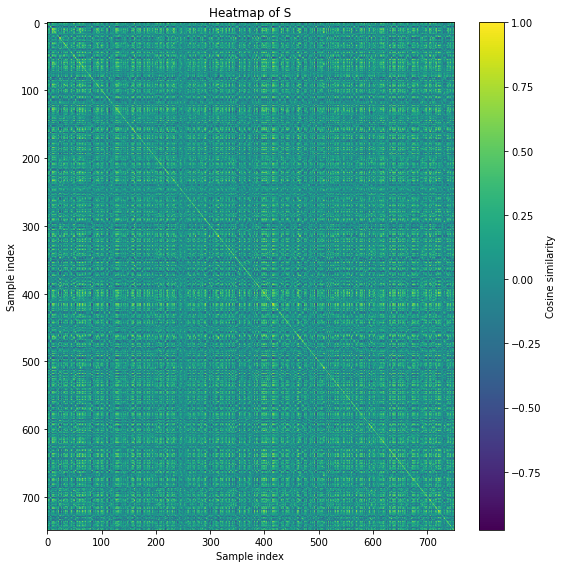

In [65]:
import matplotlib.pyplot as plt

# S is your cosine‐similarity matrix, shape (n_samples, n_samples)
plt.figure(figsize=(8, 8))           # make it square
plt.imshow(S, aspect='auto')         # display the matrix
plt.colorbar(label='Cosine similarity')
plt.title('Heatmap of S')
plt.xlabel('Sample index')
plt.ylabel('Sample index')
plt.tight_layout()
plt.show()


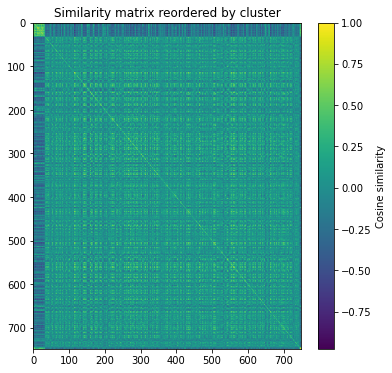

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# assume `cluster_ids` is your array of length 749
order = np.argsort(cluster_ids)            
S_ord = S[order][:, order]                

plt.figure(figsize=(6,6))
plt.imshow(S_ord, aspect='auto')
plt.colorbar(label='Cosine similarity')
plt.title('Similarity matrix reordered by cluster')
plt.show()


In [46]:
t.shape

(1, 4, 28, 100)

In [47]:
z[0,:].permute(2,0,1).shape

torch.Size([3, 28, 100])

In [37]:
x.shape


torch.Size([1, 102, 100])

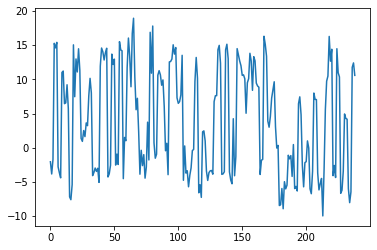

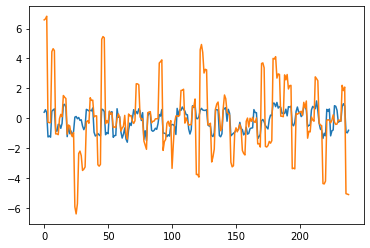

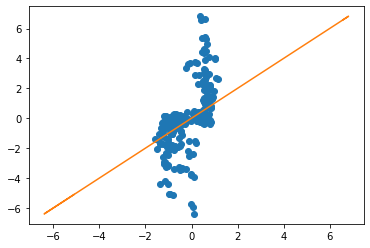

In [3]:
from matplotlib import pyplot as plt
plt.plot(feats.flatten().detach().numpy())
plt.show()
plt.plot(preds.flatten().detach().numpy())

plt.plot(y_res.flatten().detach().numpy())
plt.show()
plt.plot(preds.flatten().detach().numpy(),y_res.flatten().detach().numpy(), "o")
plt.plot(y_res.flatten().detach().numpy(),y_res.flatten().detach().numpy())
plt.show()
